## Single Decision Tree (SDT) Benchmark

H2O cloud is inicialized before every run and shutdown after every run. Algorithm is firstly tested on Training performance and after on Evaluation performance.


In [1]:
import sys
sys.path.append("h2o-py/build/main") # path to h2o build

print(sys.path)

['/Users/yuliia/diplomka/h2o-3', '/usr/local/Cellar/python@3.9/3.9.12_1/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/usr/local/Cellar/python@3.9/3.9.12_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/usr/local/Cellar/python@3.9/3.9.12_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/yuliia/diplomka/h2o-3/venv/lib/python3.9/site-packages', 'h2o-py/build/main']


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import time
import math
import random
import h2o
from h2o.estimators import H2OSingleDecisionTreeEstimator
from h2o.estimators import H2ORandomForestEstimator
from sklearn.tree import DecisionTreeClassifier

versionFromGradle='3.37.0',projectVersion='3.37.0.99999',branch='yuliia-PUBDEV-8691-sdt',lastCommitHash='7ed8f5dfce507f975eea2c5b49d87c3e6014810a',gitDescribe='jenkins-master-5782-55-g7ed8f5dfce-dirty',compiledOn='2022-07-25 17:20:59',compiledBy='yuliia'


In [3]:
# Notebook parameters
attempt_per_thread = 1 # number of runs of the algorithm in the thread # todo - change to 5
max_depth = 5 
threds = [1, 2] #[12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]



In [4]:
def train_models(nthreads, data, start_cluster=True):
    if start_cluster:
        h2o.init(nthreads=nthreads)
    hf = h2o.H2OFrame(data)
    start = time.time()
    SDT_h2o = H2OSingleDecisionTreeEstimator(model_id = "single_decision_tree.hex", max_depth=max_depth)
    SDT_h2o.train(training_frame = hf, y='label')
    end = time.time()
    sdt_time = end - start
    print(f"SDT Time: {sdt_time}s")
    start = time.time()
    DRF_h2o = H2ORandomForestEstimator(model_id = "random_forest.hex", ntrees = 1, max_depth = max_depth, 
                                       sample_rate=1, score_tree_interval=2)
    hf['label'].asfactor()
    DRF_h2o.train(training_frame = hf, y='label')
    end = time.time()
    drf_time = end - start
    print(f"DRF Time: {drf_time}s")
    if start_cluster:
        h2o.cluster().shutdown()
        time.sleep(10)
    return sdt_time, drf_time


def run_benchmark(data, start_cluster=True):
    all_times = []
    all_times_num_sdt = []
    all_times_num_drf = []
    for nthreads in threds:
        times_sdt = []
        times_drf = []
        for i in range(attempt_per_thread):
            sdt_time, drf_time = train_models(nthreads, data, start_cluster)
            times_sdt.append(sdt_time)
            times_drf.append(drf_time)
        print(f"SDT {np.mean(times_sdt)}s")
        print(f"DRF {np.mean(times_drf)}s")
        all_times_num_sdt.append(times_sdt)
        all_times_num_drf.append(times_drf)
        all_times.append(f"thread {nthreads} - SDT {np.mean(times_sdt)}s and DRF {np.mean(times_drf)}s")

    sdt_means = dict()
    drf_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - SDT = {np.mean(all_times_num_sdt[i])}, DRF = {np.mean(all_times_num_drf[i])}")
        sdt_means[nthreads] = np.mean(all_times_num_sdt[i])
        drf_means[nthreads] = np.mean(all_times_num_drf[i])
    
    return sdt_means, drf_means
        
    
def plot_result(sdt_means, drf_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in sdt_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_drf = {"x":[], "y": [], "label":[]}
    for label, coord in drf_means.items():
        data_drf["x"].append(label)
        data_drf["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="SDT", linewidth=3)
    plt.plot(data_drf['x'], data_drf['y'], '-', label="DRF", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Single Decision Tree - training benchmark\nModel: max_depth = {max_depth}")
    plt.savefig(f"h2o-scale-perf.png", bbox_inches='tight', pad_inches=.05)
    plt.show()



## Training stage


### Big data and small dimension

In [5]:
X = pd.read_csv("smalldata/yuliia/Dataset1_train.csv")
sdt_time1, drf_time1 = run_benchmark(X)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.3" 2022-04-19 LTS; OpenJDK Runtime Environment Corretto-17.0.3.6.1 (build 17.0.3+6-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.3.6.1 (build 17.0.3+6-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/diplomka/h2o-3/build/h2o.jar
  Ice root: /var/folders/4y/b9qskph514qdxlwlds_gf79w0000gn/T/tmp9repjo0o
  JVM stdout: /var/folders/4y/b9qskph514qdxlwlds_gf79w0000gn/T/tmp9repjo0o/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/4y/b9qskph514qdxlwlds_gf79w0000gn/T/tmp9repjo0o/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,2 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_yuliia_o4jjd2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |

/Users/yuliia/diplomka/h2o-3/h2o-py/build/main/h2o/estimators/estimator_base.py:208: RuntimeWarning: Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
SDT Time: 0.385037899017334s
drf Model Build progress: |

/Users/yuliia/diplomka/h2o-3/h2o-py/build/main/h2o/estimators/estimator_base.py:208: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
DRF Time: 1.7072381973266602s
H2O session _sid_a53c closed.
SDT 0.385037899017334s
DRF 1.7072381973266602s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.3" 2022-04-19 LTS; OpenJDK Runtime Environment Corretto-17.0.3.6.1 (build 17.0.3+6-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.3.6.1 (build 17.0.3+6-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/diplomka/h2o-3/build/h2o.jar
  Ice root: /var/folders/4y/b9qskph514qdxlwlds_gf79w0000gn/T/tmpd43llxfi
  JVM stdout: /var/folders/4y/b9qskph514qdxlwlds_gf79w0000gn/T/tmpd43llxfi/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/4y/b9qskph514qdxlwlds_gf79w0000gn/T/tmpd43llxfi/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,2 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_yuliia_a4pop7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 0.3421638011932373s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 1.4986231327056885s
H2O session _sid_85c7 closed.
SDT 0.3421638011932373s
DRF 1.4986231327056885s
1 - SDT = 0.385037899017334, DRF = 1.7072381973266602
2 - SDT = 0.3421638011932373, DRF = 1.4986231327056885


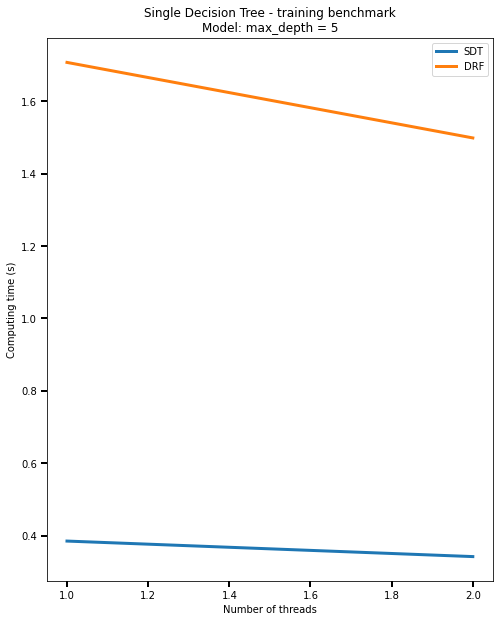

In [6]:
plot_result(sdt_time1, drf_time1)

### Big data and big dimension

In [7]:
X = pd.read_csv("smalldata/yuliia/HIGGS_train_limited1.csv")
sdt_time2, drf_time2 = run_benchmark(X)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.3" 2022-04-19 LTS; OpenJDK Runtime Environment Corretto-17.0.3.6.1 (build 17.0.3+6-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.3.6.1 (build 17.0.3+6-LTS, mixed mode, sharing)
  Starting server from /Users/yuliia/diplomka/h2o-3/build/h2o.jar
  Ice root: /var/folders/4y/b9qskph514qdxlwlds_gf79w0000gn/T/tmp352o8k1i
  JVM stdout: /var/folders/4y/b9qskph514qdxlwlds_gf79w0000gn/T/tmp352o8k1i/h2o_yuliia_started_from_python.out
  JVM stderr: /var/folders/4y/b9qskph514qdxlwlds_gf79w0000gn/T/tmp352o8k1i/h2o_yuliia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,2 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_yuliia_2vht8r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |

/Users/yuliia/diplomka/h2o-3/h2o-py/build/main/h2o/estimators/estimator_base.py:208: RuntimeWarning: Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
SDT Time: 3.012586832046509s
drf Model Build progress: |

/Users/yuliia/diplomka/h2o-3/h2o-py/build/main/h2o/estimators/estimator_base.py:208: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
DRF Time: 7.577459335327148s
H2O session _sid_9ccb closed.
SDT 3.012586832046509s
DRF 7.577459335327148s
Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 min 35 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.37.0.99999
H2O_cluster_version_age:,2 hours and 27 minutes
H2O_cluster_name:,yuliia
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.518 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
sdt Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
SDT Time: 1.0623259544372559s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF Time: 4.78842306137085s


H2OResponseError: Server error water.exceptions.H2ONotFoundArgumentException:
  Error: Resource /flow/index.html not found
  Request: GET /


In [ ]:
plot_result(sdt_time2, drf_time2)

## Evaluation Stage

In [ ]:
def run_predict(SDT_model, DRF_model, test):
    start = time.time()
    SDT_model.predict(test)
    end = time.time()
    sdt_time = end - start
    print(f"SDT Time: {sdt_time}s")
    start = time.time()
    DRF_model.predict(test)
    end = time.time()
    drf_time = end - start
    print(f"DRF Time: {drf_time}s")    
    return sdt_time, drf_time


def run_predict_benchmark(train_data, test_data):
    all_times = []
    all_times_num_sdt = []
    all_times_num_drf = []
    for nthreads in threds:
        times_sdt = []
        times_drf = []
        h2o.init(nthreads=nthreads)     
        train = h2o.H2OFrame(train_data)    
        test = h2o.H2OFrame(test_data)
        SDT_model = H2OSingleDecisionTreeEstimator(model_id = "single_decision_tree.hex", max_depth=max_depth)
        SDT_model.train(training_frame = train, y='label')
        DRF_model = H2ORandomForestEstimator(model_id="random_forest.hex", ntrees=1, max_depth=max_depth,
                                             sample_rate=1, score_tree_interval=2)
        train['label'].asfactor()
        DRF_model.train(training_frame = train, y='label')
        for i in range(attempt_per_thread):
            sdt_time, drf_time = run_predict(SDT_model, DRF_model, test)
            times_SDT.append(SDT_time)
            times_DRF.append(DRF_time)
        h2o.cluster().shutdown()
        print(f"SDT {np.mean(times_sdt)}s")
        print(f"DRF {np.mean(times_drf)}s")
        all_times_num_sdt.append(times_sdt)
        all_times_num_drf.append(times_drf)
        all_times.append(f"thread {nthreads} - SDT {np.mean(times_sdt)}s and DRF {np.mean(times_drf)}s")
        
        
    sdt_means = dict()
    drf_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - SDT = {np.mean(all_times_num_sdt[i])}, DRF = {np.mean(all_times_num_drf[i])}")
        sdt_means[nthreads] = np.mean(all_times_num_sdt[i])
        drf_means[nthreads] = np.mean(all_times_num_drf[i])

    return sdt_means, drf_means 

def plot_predict(SDT_means, DRF_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in SDT_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_drf = {"x":[], "y": [], "label":[]}
    for label, coord in DRF_means.items():
        data_drf["x"].append(label)
        data_drf["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="SDT", linewidth=3)
    plt.plot(data_drf['x'], data_drf['y'], '-', label="DRF", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Single Decision Tree - evaluation benchmark\nModel: max_depth = {max_depth}")
    plt.savefig(f"h2o-eval-perf.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [ ]:
# Evaluation stage parameters
X_train = pd.read_csv("smalldata/yuliia/HIGGS_train_limited1.csv")
X_test = pd.read_csv("smalldata/yuliia/HIGGS_test_limited1.csv")
sdt_time3, drf_time3 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(sdt_time3, drf_time3)